CQF Final project

"We need to test if time-series are weakly stationary, or integrated of order zero (I(0)), if its statistical properties—specifically its mean, variance, and autocovariance—are invariant with respect to time. The majority of financial price series do not exhibit this property; they are typically non-stationary and contain a unit root, meaning they are integrated of order one (I(1)). A critical issue arises when standard regression techniques are applied to I(1) series. Regressing one I(1) series on another can lead to a "spurious regression," a situation where high R-squared values and statistically significant coefficients are observed even when no genuine economic relationship exists between the variables. This necessitates formal testing for stationarity."

The augmented Dickey–Fuller specification is:

$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1}
        + \sum_{i=1}^{p} \delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

The hypotheses are:

- Null hypothesis: $H_0: \gamma = 0$
  (implying a unit root; the series is non-stationary)

- Alternative hypothesis: $H_1: \gamma < 0$
  (implying stationarity)


The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test statistic for trend‐stationarity is given by

$$
\mathrm{KPSS} \;=\;
\frac{1}{T^2} \sum_{t=1}^T S_t^2 \;\bigg/\; \widehat{\sigma}^2
$$

where

$S_t = \sum_{i=1}^t \widehat{u}_i$

$\widehat{u}_i = y_i - \widehat{\beta}_0 - \widehat{\beta}_1\,i$
are the residuals from the OLS regression of \(y_t\) on an intercept and time trend.  
$(\widehat{\sigma}^2\)$ is a consistent estimate of the long‐run variance of $(\widehat{u}_t\)$, often computed via a Newey–West estimator:
  $$
  \widehat{\sigma}^2
  = \frac{1}{T}\sum_{t=1}^T \widehat{u}_t^2
    \;+\; 2 \sum_{\ell=1}^L w\bigl(\ell,L\bigr)\,
    \frac{1}{T}\sum_{t=\ell+1}^T \widehat{u}_t\,\widehat{u}_{t-\ell},
  $$
  with Bartlett weights \(w(\ell,L)=1-\ell/(L+1)\).

The hypotheses reverse those of the ADF:

- **Null hypothesis** (stationarity around a deterministic trend):  
  $$H_0:\; \{y_t\}\text{ is trend‐stationary}$$

- **Alternative hypothesis** (presence of a unit root):  
  $$H_1:\; \{y_t\}\text{ has a unit root (non‐stationary)}$$

**Interpretation:**  
- A large KPSS statistic leads to rejection of \(H_0\), suggesting non‐stationarity.  
- Used alongside the ADF:  
  - **Fail to reject ADF null** (evidence of unit root) **and** **reject KPSS null** (evidence against stationarity) ⇒ strong confirmation that \(y_t\) is \(I(1)\).


## Statistical Analysis and Threshold Optimization

This section performs the statistical tests and threshold optimization for the downloaded asset groups.

In [1]:
from datetime import datetime, timedelta

import pandas as pd

from data_download import fetch_asset_data
from coint_tests import engle_granger, ou_params, summarize_cointegration_tests, run_pair_backtests
from pair_selection_summary import assemble_group_summary
from backtest import nested_cv, generate_signals
from plotting import plot_performance, analyze_pairs_nb


pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
end_date   = datetime.now()
start_date = end_date - timedelta(days=5*365)

asset_groups = {
    # Commodities
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],    # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                          # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                         # Corn, Soybean Futures

    # Fixed Income & Currency
    "yield_pair": ["^TNX", "IGLT.L"],                      # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],             # AUD/USD, CAD/USD

    # Volatility
    "volatility_pair": ["^VIX", "VIXY"],                   # US VIX Index vs. Short-Term VIX Futures ETF*

    # Country Indices
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],                # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],            # IBEX 35, FTSE MIB

    # Equities
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],               # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],            # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],        # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],             # VW, Porsche AG
    "semiconductor_pair": ["ASML.AS", "IFX.DE"],           # ASML, Infineon

    # ETFs
    "sector_etf_pair": ["XLRE", "XLU"]                     # Real Estate ETF, Utilities ETF
}

all_data = fetch_asset_data(asset_groups, start_date, end_date)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********

In [3]:
summary_df = summarize_cointegration_tests(all_data)

summary_df

,group,asset,stat,pvalue,crit_1%,crit_5%,crit_10%,crit_2.5%,test,johansen_n,...,eg_pvalue,const,slope,ou_mu,ou_theta,ou_halflife,ou_sigma,ecm_coeff,ecm_pvalue,kf_beta_mean
0,precious_metals_triple,GC=F,4.11,0.01,0.74,0.46,0.35,0.57,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,precious_metals_triple,PL=F,0.46,0.05,0.74,0.46,0.35,0.57,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,precious_metals_triple,SI=F,2.62,0.01,0.74,0.46,0.35,0.57,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,precious_metals_triple,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Johansen,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,oil_pair,BZ=F,1.25,0.01,0.74,0.46,0.35,0.57,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,sector_etf_pair,XLRE,1.11,0.01,0.74,0.46,0.35,0.57,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,sector_etf_pair,XLU,3.87,0.01,0.74,0.46,0.35,0.57,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,sector_etf_pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Engle-Granger,NaN,...,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,sector_etf_pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matrix-OLS,NaN,...,NaN,15.72,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
summary = assemble_group_summary(all_data)

summary

,group,n_assets,eg_pvalue,joh_n_relations,ou_halflife,ou_sigma,sharpe_spread,beta_stability,ecm_pvalue,Z_star,N_trades_Zstar,avg_PnL_Zstar
0,precious_metals_triple,3,NaN,0.00,26.17,1.49,1.46,NaN,NaN,3.00,0.00,NaN
1,oil_pair,2,0.00,NaN,8.36,1.47,1.28,0.02,0.00,0.50,43.00,1.71
2,agri_pair,2,0.01,NaN,36.86,52.21,-1.93,0.10,0.00,1.40,10.00,91.34
3,yield_pair,2,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,currency_pair,2,0.03,NaN,39.45,0.02,-14.78,0.06,0.00,0.70,11.00,0.02
5,volatility_pair,2,0.00,NaN,45.16,389.51,-0.94,3.39,0.00,0.80,3.00,722.30
6,eu_index_pair_1,2,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,eu_index_pair_2,2,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,fr_banking_pair,2,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,fast_fashion_pair,2,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


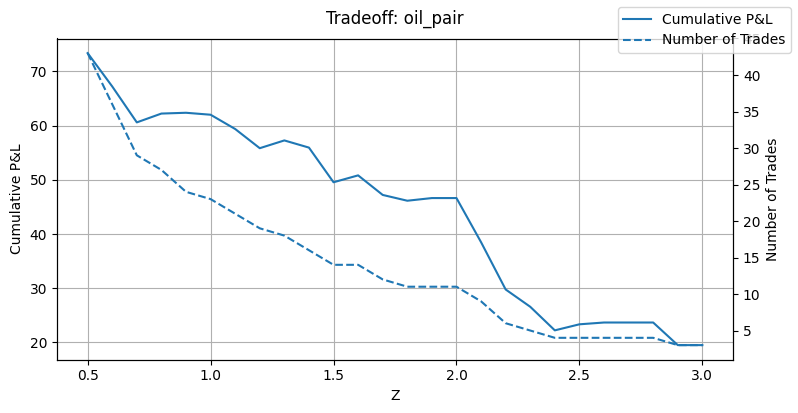

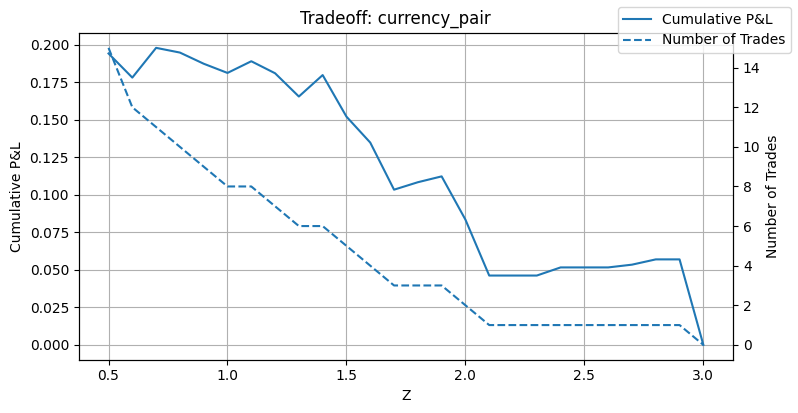

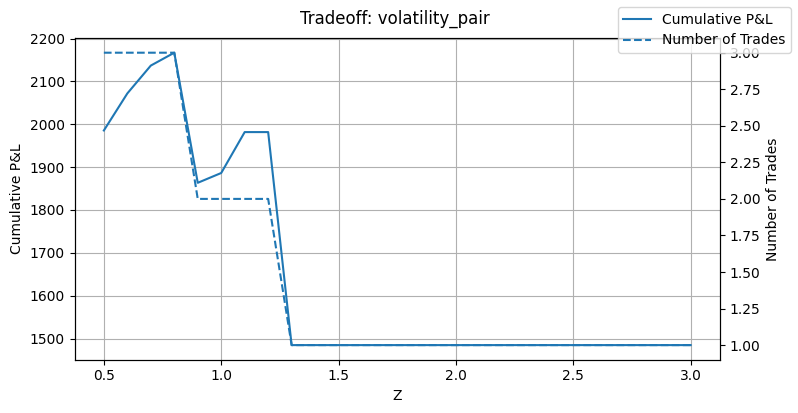

,pair,best_Z,N_trades,cum_PnL,avg_PnL
0,oil_pair,0.50,43.00,73.36,1.71
1,currency_pair,0.70,11.00,0.20,0.02
2,volatility_pair,0.80,3.00,2166.90,722.30


In [5]:
selected = ["oil_pair", "currency_pair", "volatility_pair"]
summary_df, opt_tables = analyze_pairs_nb(
    all_data,
    selected,
    Z_min=0.5,
    Z_max=3.0,
    dZ=0.1,
    cost=0.002
)

summary_df

Oil Pair (WTI vs. Brent): The WTI vs Brent spread csn be driven by physical market factors such regional supply bottlenecks, pipeline outages, and differing quality grades. Also macro drivers like OPEC quotas can impact the supply of WTI/Brent asymetrically. A structural break might occur if pipeline infrastructure is upgraded or if new export policies realign U.S. crude balances which could permanently narrow or widen the spread. Geopolitical events (Libyan civil unrest, U.S. shale booms) can induce regime shifts. These fundamental drivers can pivot the long run equilibrium defined by past price differentials and the signal might then no longer hold.

Currency Pair (AUD/USD vs. CAD/USD) & Volatility Pair (VIX vs. VIXY): The AUD–CAD cross owes its co movement to both being commodity currencies, but central bank divergence e.g. the RBA cutting rates sharply while the BoC remains hawkish can decouple their rates and break the historical cointegration. For VIX vs VIXY structural breaks arise when futures curve dynamics change, a systemic shift in collateral demand or a persistent volatility regime (e.g. prolonged low volatility or crisis spikes) can alter the term structure roll yield that VIXY captures. In both cases, a shifting monetary policy stance or a regime change in risk aversion can turn the once stationary spread into a drifting series.

In [6]:
pair_results = run_pair_backtests(
    selected=selected,
    all_data=all_data,
    z_list=[0.5, 1.0, 1.5, 2.0],
    train_months=18,
    test_months=6,
    step_months=3
)

pair_results

{'oil_pair':    train_start   train_end  test_start    test_end  best_z  train_sharpe  \
 0   2020-07-23  2022-01-23  2022-01-23  2022-07-23    0.50          1.67   
 1   2020-10-23  2022-04-23  2022-04-23  2022-10-23    1.00          2.09   
 2   2021-01-23  2022-07-23  2022-07-23  2023-01-23    0.50          2.04   
 3   2021-04-23  2022-10-23  2022-10-23  2023-04-23    0.50          1.86   
 4   2021-07-23  2023-01-23  2023-01-23  2023-07-23    0.50          1.78   
 5   2021-10-23  2023-04-23  2023-04-23  2023-10-23    1.00          1.71   
 6   2022-01-23  2023-07-23  2023-07-23  2024-01-23    0.50          1.76   
 7   2022-04-23  2023-10-23  2023-10-23  2024-04-23    0.50          1.84   
 8   2022-07-23  2024-01-23  2024-01-23  2024-07-23    0.50          1.71   
 9   2022-10-23  2024-04-23  2024-04-23  2024-10-23    0.50          1.67   
 10  2023-01-23  2024-07-23  2024-07-23  2025-01-23    1.00          1.71   
 11  2023-04-23  2024-10-23  2024-10-23  2025-04-23    0.50     

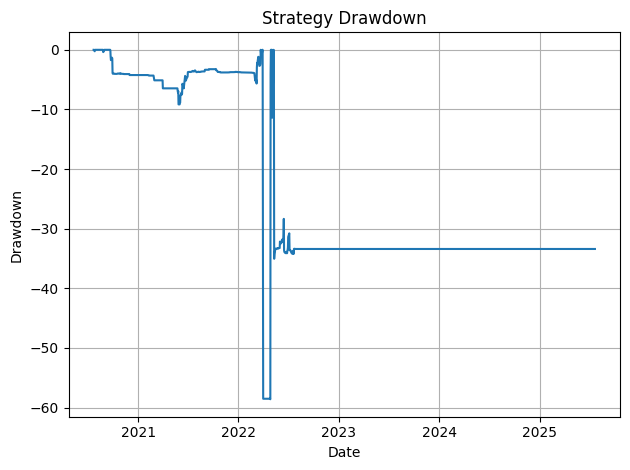

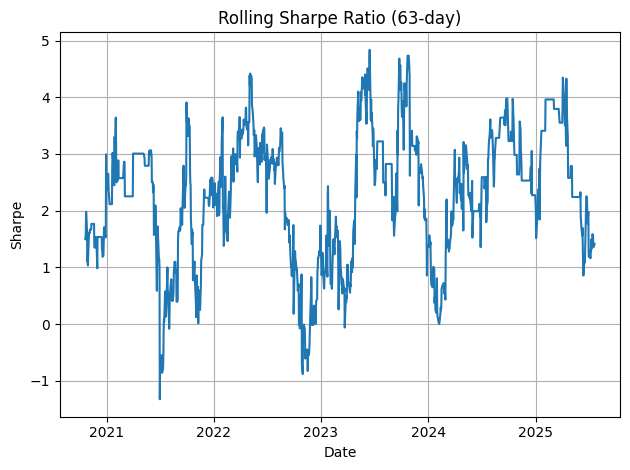

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


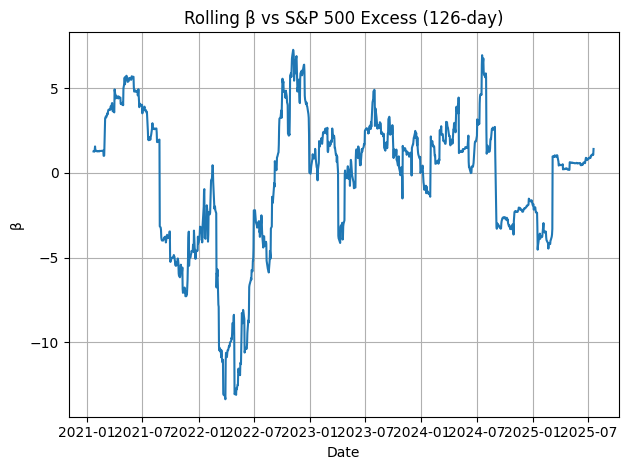

In [7]:
pnl = {}

for pair in selected:
    # 1. Recompute the spread
    df   = all_data[pair]
    y,x  = df.columns
    eg   = engle_granger(df, y, x)
    spread = eg['spread'].dropna()

    # 2. Get the optimal Z from your summary_df
    best_Z = summary_df.loc[summary_df['pair']==pair, 'best_Z'].iloc[0]

    # 3. Build the signal on that spread
    mu, sigma = spread.mean(), spread.std()
    sig = generate_signals(spread, mu, sigma, best_Z)

    # 4. Daily returns = position_{t-1} * Δspread_t
    ret = sig.shift(1) * spread.diff()

    # 5. Cumulative PnL
    pnl[pair] = ret.cumsum()

# Now for example:
vol_pnl = pnl['oil_pair']

# Convert to returns and plot
strat_ret = vol_pnl.diff().fillna(0)
plot_performance(strat_ret)